# Fractional power filter/alpha

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import skimage
import skimage.io as io

In [2]:

def FPF(data, c, fp):
    """
    FPF algorithm for computing H given data, a constraint vector c, and fp parameter.
    
    Parameters:
        data (ndarray): Incoming data in rows.
        c (ndarray): Constraint vector.
        fp (float): Parameter.
    
    Returns:
        ndarray: Computed H matrix.
    """
    (N, Dim) = data.shape

    # Compute D. Best done in rows
    D = (np.power(abs(data), fp)).sum(0)
    D = D / N

    # Handle cases where D might be close to 0
    ndx = (abs(D) < 0.001).nonzero()[0]
    D[ndx] = 0.001 * np.sign(D[ndx] + 1e9)

    # Y is the modified X. More efficient to compute from original data
    Y = data / np.sqrt(D)
    Y = Y.transpose()

    # Compute Q
    Yc = Y.conjugate().transpose()
    Q = Yc.dot(Y)  # inner product

    if N == 1:  # only 1 training vector
        Q = 1. / Q
    else:
        Q = np.linalg.inv(Q)

    Rc = Q.dot(c)
    H = Y.dot(Rc) / np.sqrt(D)
    return H


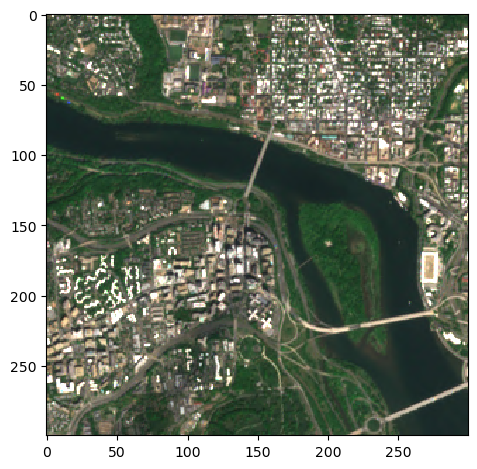

In [3]:
# Demo image
with rasterio.open('demo.jp2') as src:  # jp2 image
    red = src.read(1, masked=True)
    green = src.read(2, masked=True)
    blue = src.read(3, masked=True)

image = np.stack([red, green, blue], axis=-1)  # Restacking channels

io.imshow(image)
io.show()

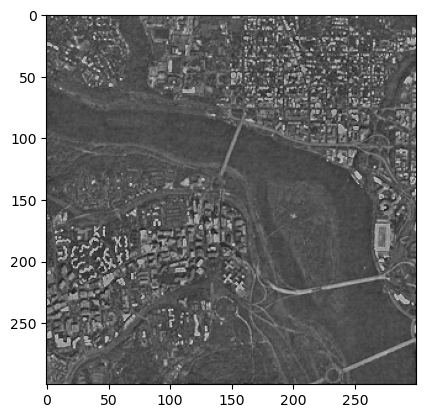

In [4]:
# Convert to grayscale
gray_image = skimage.color.rgb2gray(image)

# Apply the fractional power filter
alpha = 0.4  # Manipulate as needed (fp)
cst = np.ones(1)  # (c)
V, H = gray_image.shape
Xt = np.zeros((1, V * H), complex)
Xt[0] = np.fft.fft2(gray_image).ravel()

ffilt = FPF(Xt, cst, alpha)
filt = np.fft.ifft2(ffilt.reshape(V, H)).real

plt.imshow(filt, cmap='gray')
plt.show()

## The Underlying Concept

As the alpha value approaches one, higher intensity values become more prominent. Conversely, as alpha approaches zero, the image gets less affected. This is a result of the effects of exponents on different intensity values. For example, if your input values are (1, 5000, 100), using a higher exponent will preserve the extreme differences in values, thereby highlighting edges. However, with a lower exponent value, such as 0.1, the higher values will be significantly reduced while the lower values are less affected. This leads to blurring of the image or no effect.

## How It Works

The FPF process:

The input data (intensity values) is passed to the FPF along with a constraint vector (c) and a fractional power (fp) referred to as alpha.

The algorithm  computes the normalization factor (D) by raising the absolute values of the input data to the power of fp. This step emphasizes the contributions of different intensities based on the chosen exponent. (When a high and low value is raised to the power of x, the higher value will undergo more significant changes).

The histogram bins are found by summing up the rows of the normalization factor (D). The bins are then divided by the total number of bins (N) to obtain a normalized value.

Zero values are replaced to ensure they are not used in division.

The input data (Y) is normalized by dividing each value by the square root of the corresponding normalization factor (D).

The modified input data (Y) is then transposed.

The conjugated and transposed data (Yc) of the modified input data (Y) is computed. This involves taking the complex conjugate of each element of Y and then transposing the result which restores it to the original orientation.

The inner product (Q) is calculated by performing the dot product operation between Y and Yc. This step highlights similarities and differences between the data sets.

The inverse of the inner product (Q) is calculated using np.linalg.inv or 1/Q.

The constraint (c) is multiplied by the computed inverse (Q) to obtain the value (Rc).

Finally, the modified data (Y) from earlier is multiplied by (Rc) and divided by the square root of the normalization factor (D). This step combines the modified data, the inverse transformation (Rc), and the normalization factor to obtain the filtered output (H).




#### Absolute value

The only difference between the absolute value and regular images after the FPF is that one displays the scalar magnitude of values from the FPF and one displays the vector values.


The degree to which this filter affects an image can be highlighted with a low resolution 100x100 numpy array in place of an image.

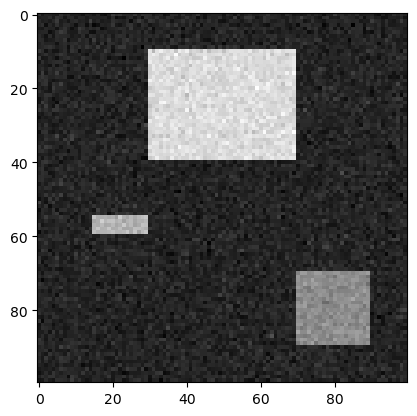

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Example image
image = np.zeros((100, 100))

# Squares
image[10:40, 30:70] = 255
image[55:60, 15:30] = 200
image[70:90, 70:90] = 145

# Add random noise
noise = np.random.normal(0, 15, size=(100, 100))
image += noise

plt.imshow(image, cmap='gray')
plt.show()


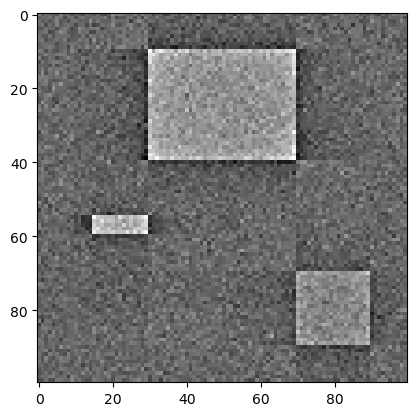

In [6]:
# Apply the fractional power filter
alpha = 0.4  # Manipulate as needed (fp)
cst = np.ones(1)  # (c)
V, H = image.shape
Xt = np.zeros((1, V * H), complex)
Xt[0] = np.fft.fft2(image).ravel()

ffilt = FPF(Xt, cst, alpha)
filt = np.fft.ifft2(ffilt.reshape(V, H)).real

plt.imshow(filt, cmap='gray')
plt.show()

# Reference list 

[1] “Google Colaboratory.” https://colab.research.google.com/drive/1vWAXTgtDvZhhuwoK0LUYXvalIKCTPlhQ?usp=sharing (accessed Jun. 28, 2023).

[2]	“The transpose of a matrix - Math Insight.” https://mathinsight.org/matrix_transpose (accessed Jun. 29, 2023).

[3]	“NumPy.” https://numpy.org/ (accessed Jun. 29, 2023).

[4]	“Inverse of a Matrix.” https://www.mathsisfun.com/algebra/matrix-inverse.html (accessed Jun. 29, 2023).

[5]	“matplotlib.pyplot.imshow — Matplotlib 3.7.1 documentation.” https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html (accessed Jun. 26, 2023).

